# <center> SABR calibration </center>

$$ df_t = \alpha_t f_t^ dW_t^1\beta $$ 
$$ d \alpha_t = v \alpha_t f_t^ dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

$$\sigma_B = \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(fK)^{1-\beta}} + \frac{\rho \beta v \alpha}{4(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)}{(fK)^{(1-\beta)/2}[1+\frac{(1-\beta)^2}{24} \ln{(\frac{f}{K})}^2 + \frac{(1-\beta)^4}{1920} \ln{(\frac{f}{K})}^4]} * \frac{z}{\xi(z)}$$
$$z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}\ln{(f/K)^2}$$
$$\xi(z) = \ln{[\frac{\sqrt{1-2z\rho+z^2}+z-\rho}{1-\rho}]}$$

Finding $\beta$:
$$\sigma_{ATM} = \sigma_{B} (f, f) =  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

$$ \ln \alpha - (1 - \beta) \ln {f} \sim \sigma^{market} $$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import numba as nb
import sys
import src.SABR.sabr_approx_div
reload(src.SABR.sabr_approx_div)
from src.SABR.sabr_approx_div import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
# raw.dt.hist(bins = 100)

CPU times: user 21.1 s, sys: 3.06 s, total: 24.2 s
Wall time: 25.6 s


In [3]:
%%time
# resample on 5 minutes
df = process_data(raw, 1)
df.head()

CPU times: user 1min, sys: 12.8 s, total: 1min 13s
Wall time: 1min 17s


,instrument,dt,mark_price,type,strike_price,expiration,underlying_price,timestamp,tau,mark_price_usd
1,ETH-10FEB23-1000-P,2023-01-27 07:49:00,0.0010,put,1000,1675987200000000,1581.870219,1674805740000000,0.037464,1.581870
3,ETH-10FEB23-1100-P,2023-01-27 07:49:00,0.0015,put,1100,1675987200000000,1581.870219,1674805740000000,0.037464,2.372805
5,ETH-10FEB23-1150-P,2023-01-27 07:49:00,0.0020,put,1150,1675987200000000,1581.870219,1674805740000000,0.037464,3.163740
7,ETH-10FEB23-1200-P,2023-01-27 07:49:00,0.0025,put,1200,1675987200000000,1581.870219,1674805740000000,0.037464,3.954676
9,ETH-10FEB23-1250-P,2023-01-27 07:49:00,0.0035,put,1250,1675987200000000,1581.870219,1674805740000000,0.037464,5.536546


# Params dynamics

In [4]:
%%time
df_for_pnl = pd.DataFrame(columns = ['type', 'strike_price', 'expiration', 'underlying_price', 'iv',
       'calibrated_iv', 'calibrated_mark_price', 'delta', 
        'vega', 'gamma' ,'sega', 'rega', 'volga', 'vanna', 'mark_price_usd', 'rho',
                        'volvol', 'alpha', 'beta', 'timestamp', "tau"])

timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(0.7)
v = np.float64(1.3)
beta = np.float64(0.9)  
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = calibr_borders, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = calibr_borders, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta", beta = 1.0)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


# timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
timestamps = calibr_borders["dt"].unique()
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                    timestamp = timestamp, calibration_type = "all")
        # we want to count unexpected pnl on beta fixed calibration variant
        calibrated_params_beta, error_beta, for_pnl = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                    timestamp = timestamp, calibration_type = "beta", beta = 1.0)
        for_pnl["timestamp"] = timestamp

        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        params_beta.append(calibrated_params_beta)
        errors_beta.append(error_beta)
        timestamps_hm.append(timestamp)
        df_for_pnl = df_for_pnl.append(for_pnl)
        
    except:
        calibrated_params_all = start_params
        print("Error!")

params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [21.221, 5.285, 0.523, 0.014] error: 0.016106174601827786
Beta first calibrated: [0.613, 5.026, 1.0, -0.109] error: 0.013908443216273585


  0%|          | 0/1381 [00:00<?, ?it/s]

CPU times: user 1min 53s, sys: 1.92 s, total: 1min 55s
Wall time: 1min 54s


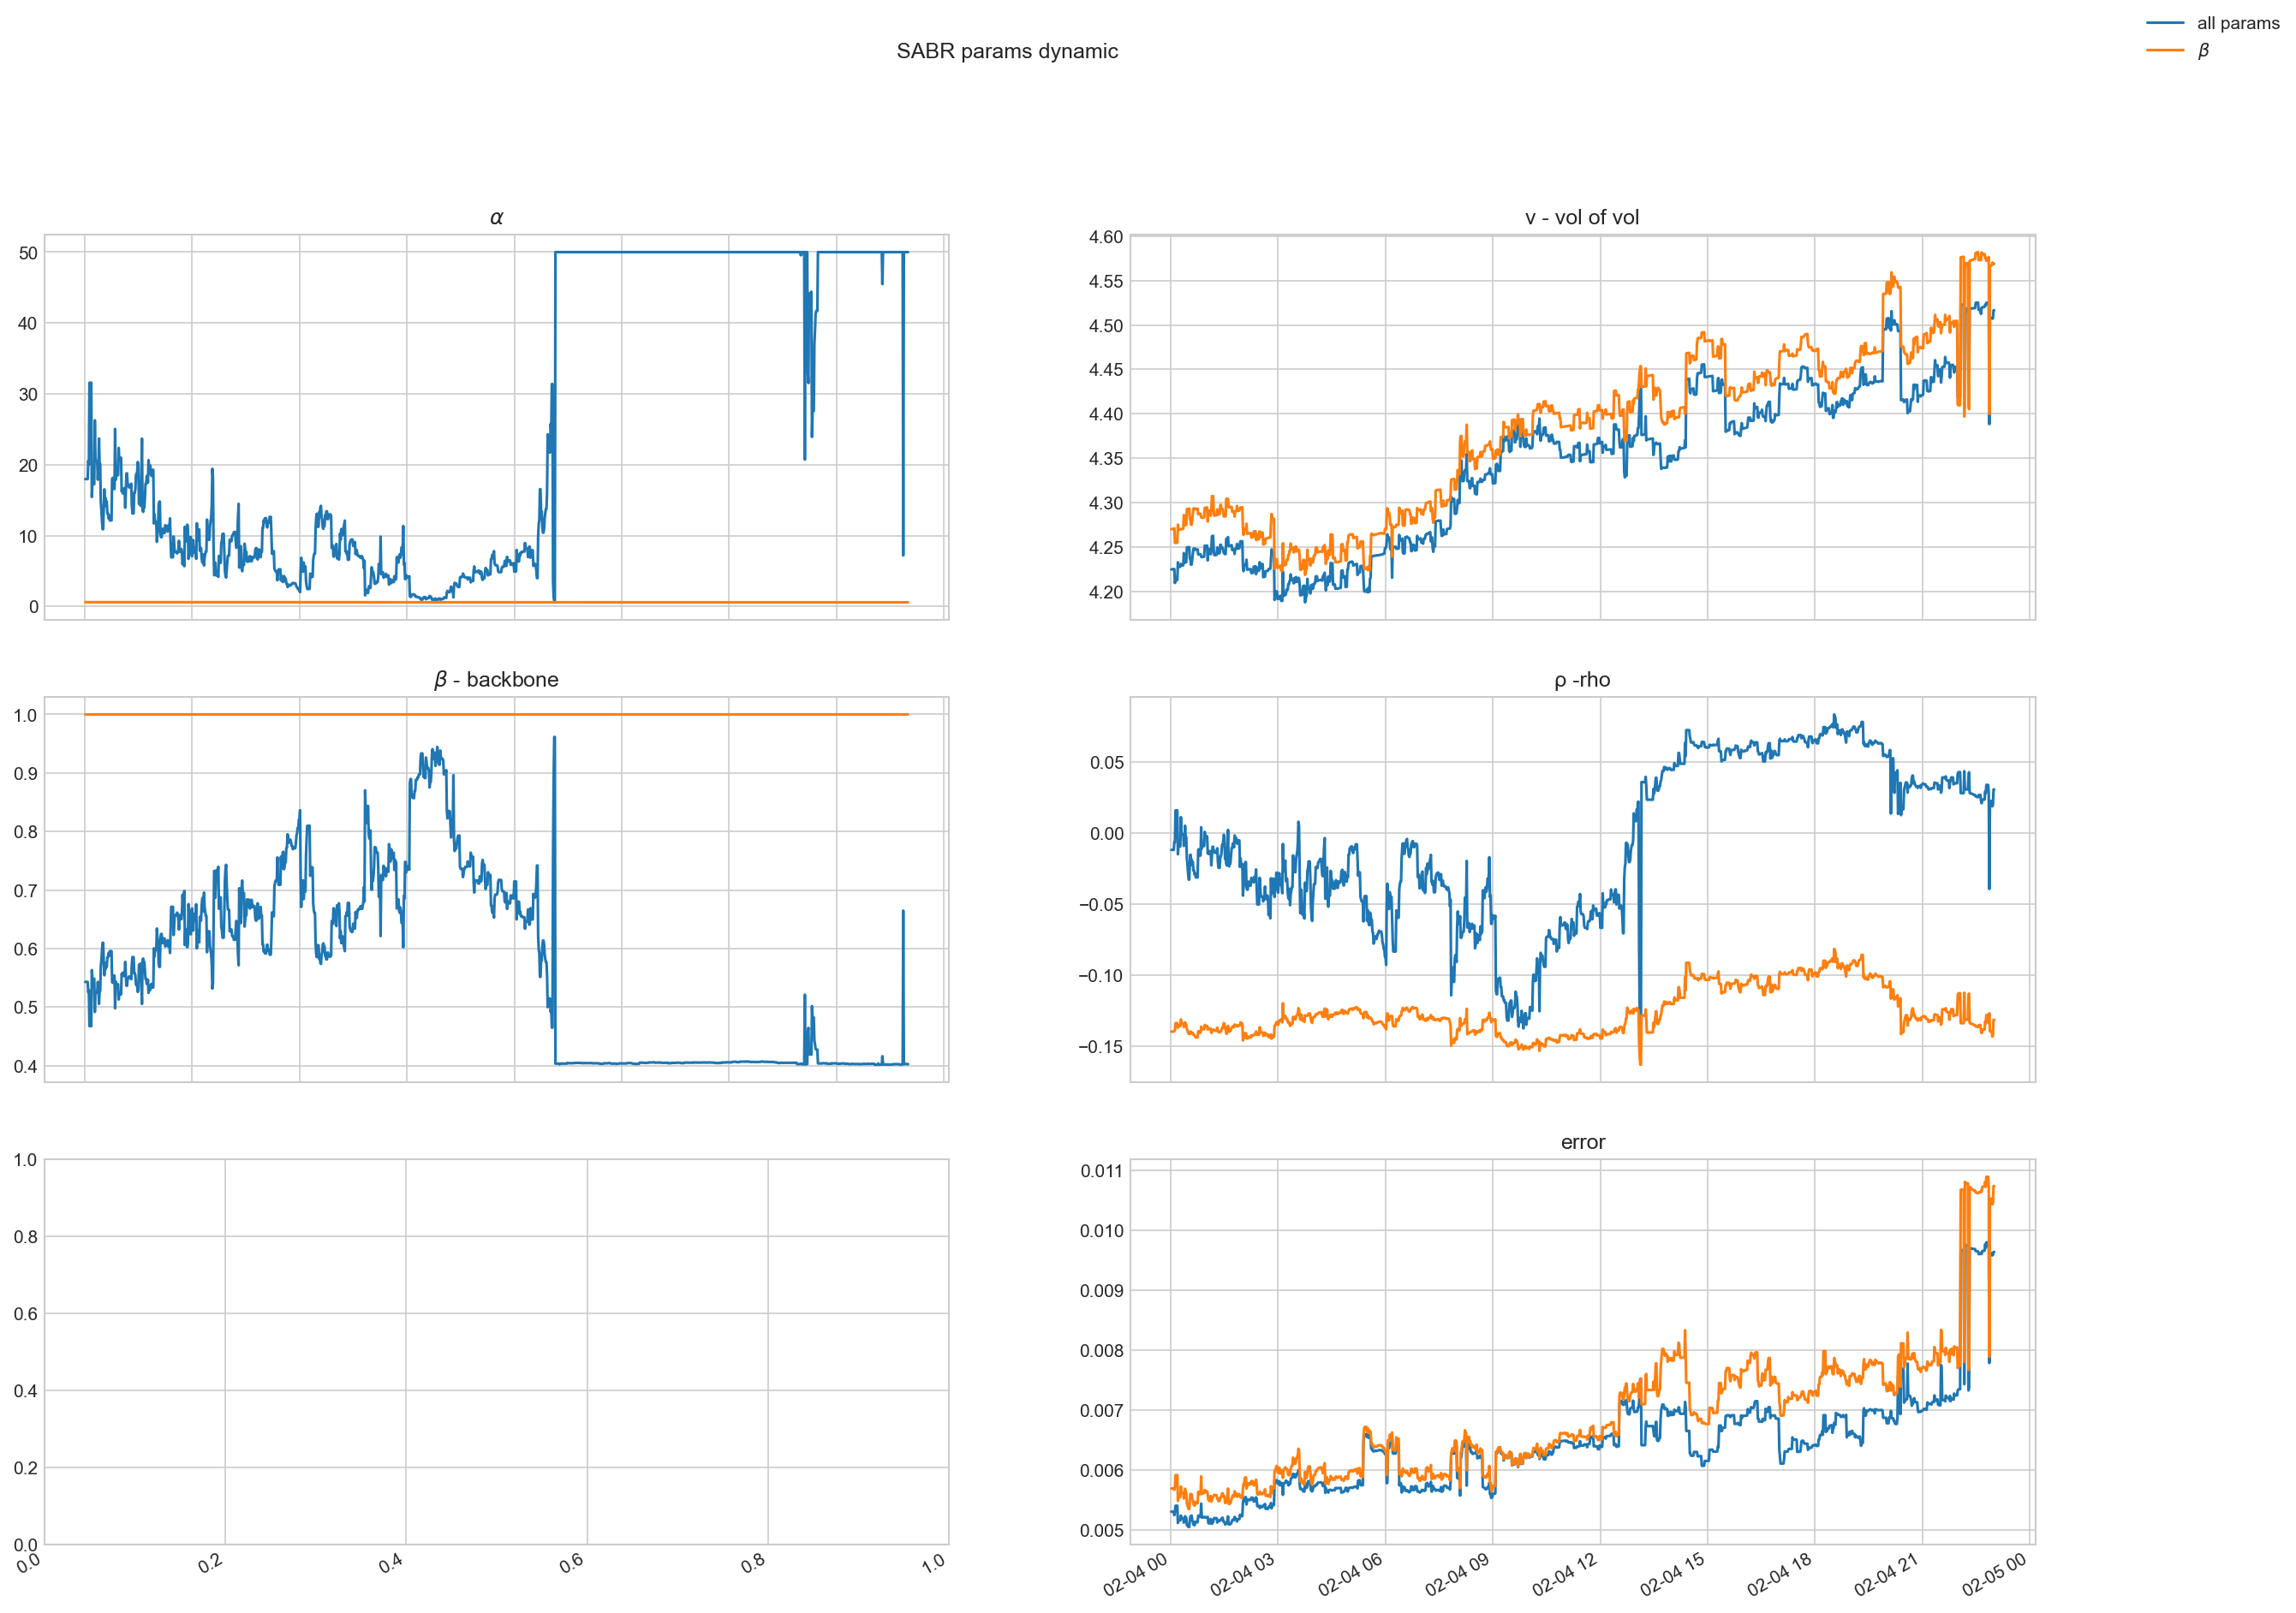

In [5]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15), dpi = 150)

axs[0, 0].plot(timestamps_hm[1:], params_all[0][1:], label = "all params")
axs[0, 1].plot(timestamps_hm[1:], params_all[1][1:])
axs[1, 0].plot(timestamps_hm[1:], params_all[2][1:])
axs[1, 1].plot(timestamps_hm[1:], params_all[3][1:])
axs[2, 1].plot(timestamps_hm[1:], errors_all[1:])

axs[0, 0].plot(timestamps_hm[1:], params_beta[0][1:], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm[1:], params_beta[1][1:])
axs[1, 0].plot(timestamps_hm[1:], params_beta[2][1:])
axs[1, 1].plot(timestamps_hm[1:], params_beta[3][1:])
axs[2, 1].plot(timestamps_hm[1:], errors_beta[1:])


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")

plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Unexplained PNL

In [6]:
def get_pnl(df: pd.DataFrame, strike:int,  option_type: str = "call"):
    data = df[(df["strike_price"] == strike) & (df["type"] == option_type)].copy()
    assert len(data)!=0, "Choose from available out of the money strikes"
#     data["mark_price_usd"] = data["mark_price"]*data["underlying_price"]
    data["calibrated_iv"] = data["calibrated_iv"]/100
    data["underlying_price_shift"] = data["underlying_price"].shift(-1)
    data["mark_price_usd_shift"] = data["mark_price_usd"].shift(-1)
#     data["calibrated_iv_shift"] = data["calibrated_iv"].shift(-1)
    data["alpha_shift"] = data["alpha"].shift(-1)
    data["rho_shift"] = data["rho"].shift(-1)
    data["volvol_shift"] = data["volvol"].shift(-1)
    data["expected_pnl"] = (data["mark_price_usd_shift"] - data["mark_price_usd"] - 
                            data["delta"]*(data["underlying_price_shift"] - data["underlying_price"]) -
                            data["vega"]*(data["alpha_shift"] - data["alpha"]) - 
                            data["sega"]*(data["rho_shift"] - data["rho"]) - 
                            data["rega"]*(data["volvol_shift"] - data["volvol"]) -
                            1/2*data["gamma"]*(data["underlying_price_shift"] - data["underlying_price"])**2 -
                            1/2*data["volga"]*(data["alpha_shift"] - data["alpha"])**2 - 
                            1/2*data["vanna"]*(data["alpha_shift"] - data["alpha"])*(data["underlying_price_shift"] - data["underlying_price"])
                           )
    return data


Text(0.5, 0, 'date')

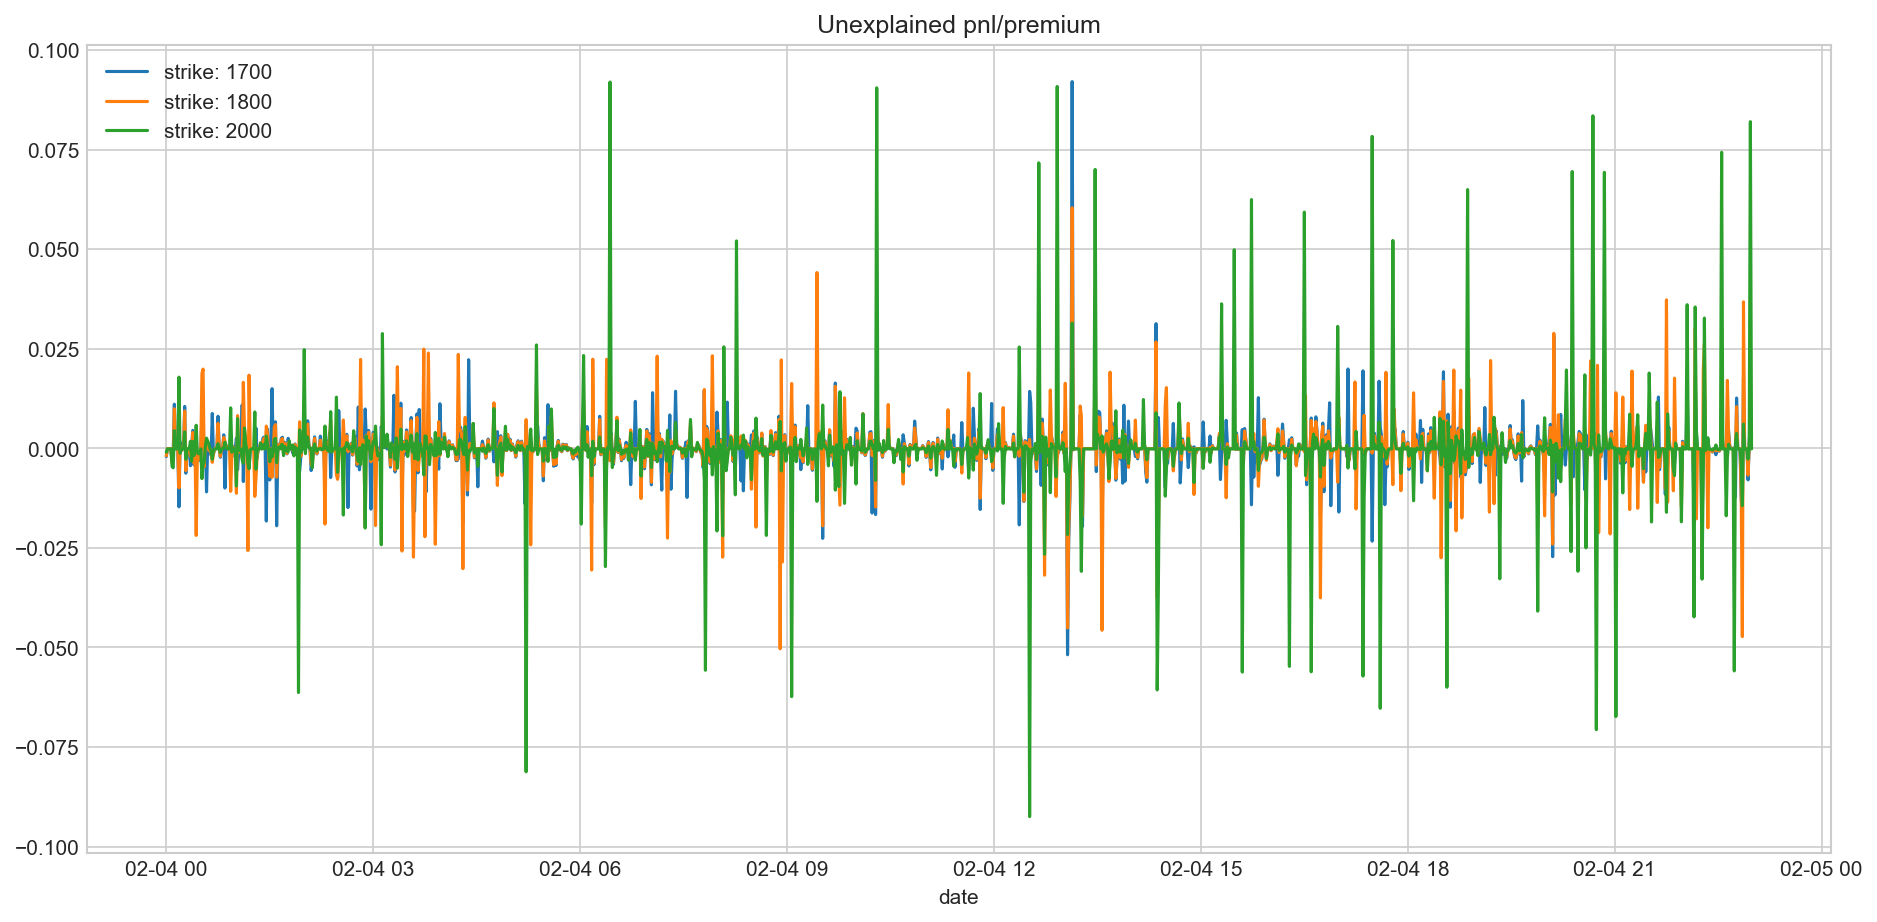

In [7]:
figure(figsize=(15, 7), dpi=150)
plt.title(f"Unexplained pnl/premium")

strikes_to_plot = [1700, 1800, 2000]
for strike in strikes_to_plot:
    data = get_pnl(df_for_pnl, strike)
    plt.plot(data["timestamp"], data["expected_pnl"]/data["mark_price_usd"], label = f"strike: {strike}")
plt.legend()
plt.xlabel("date")

# Volatility smile

All:
[40.685, 9.632, 0.416, -0.003]
0.011777174278440872
   
Beta:
[0.54, 9.69, 1.0, -0.091]
0.011945643855454359


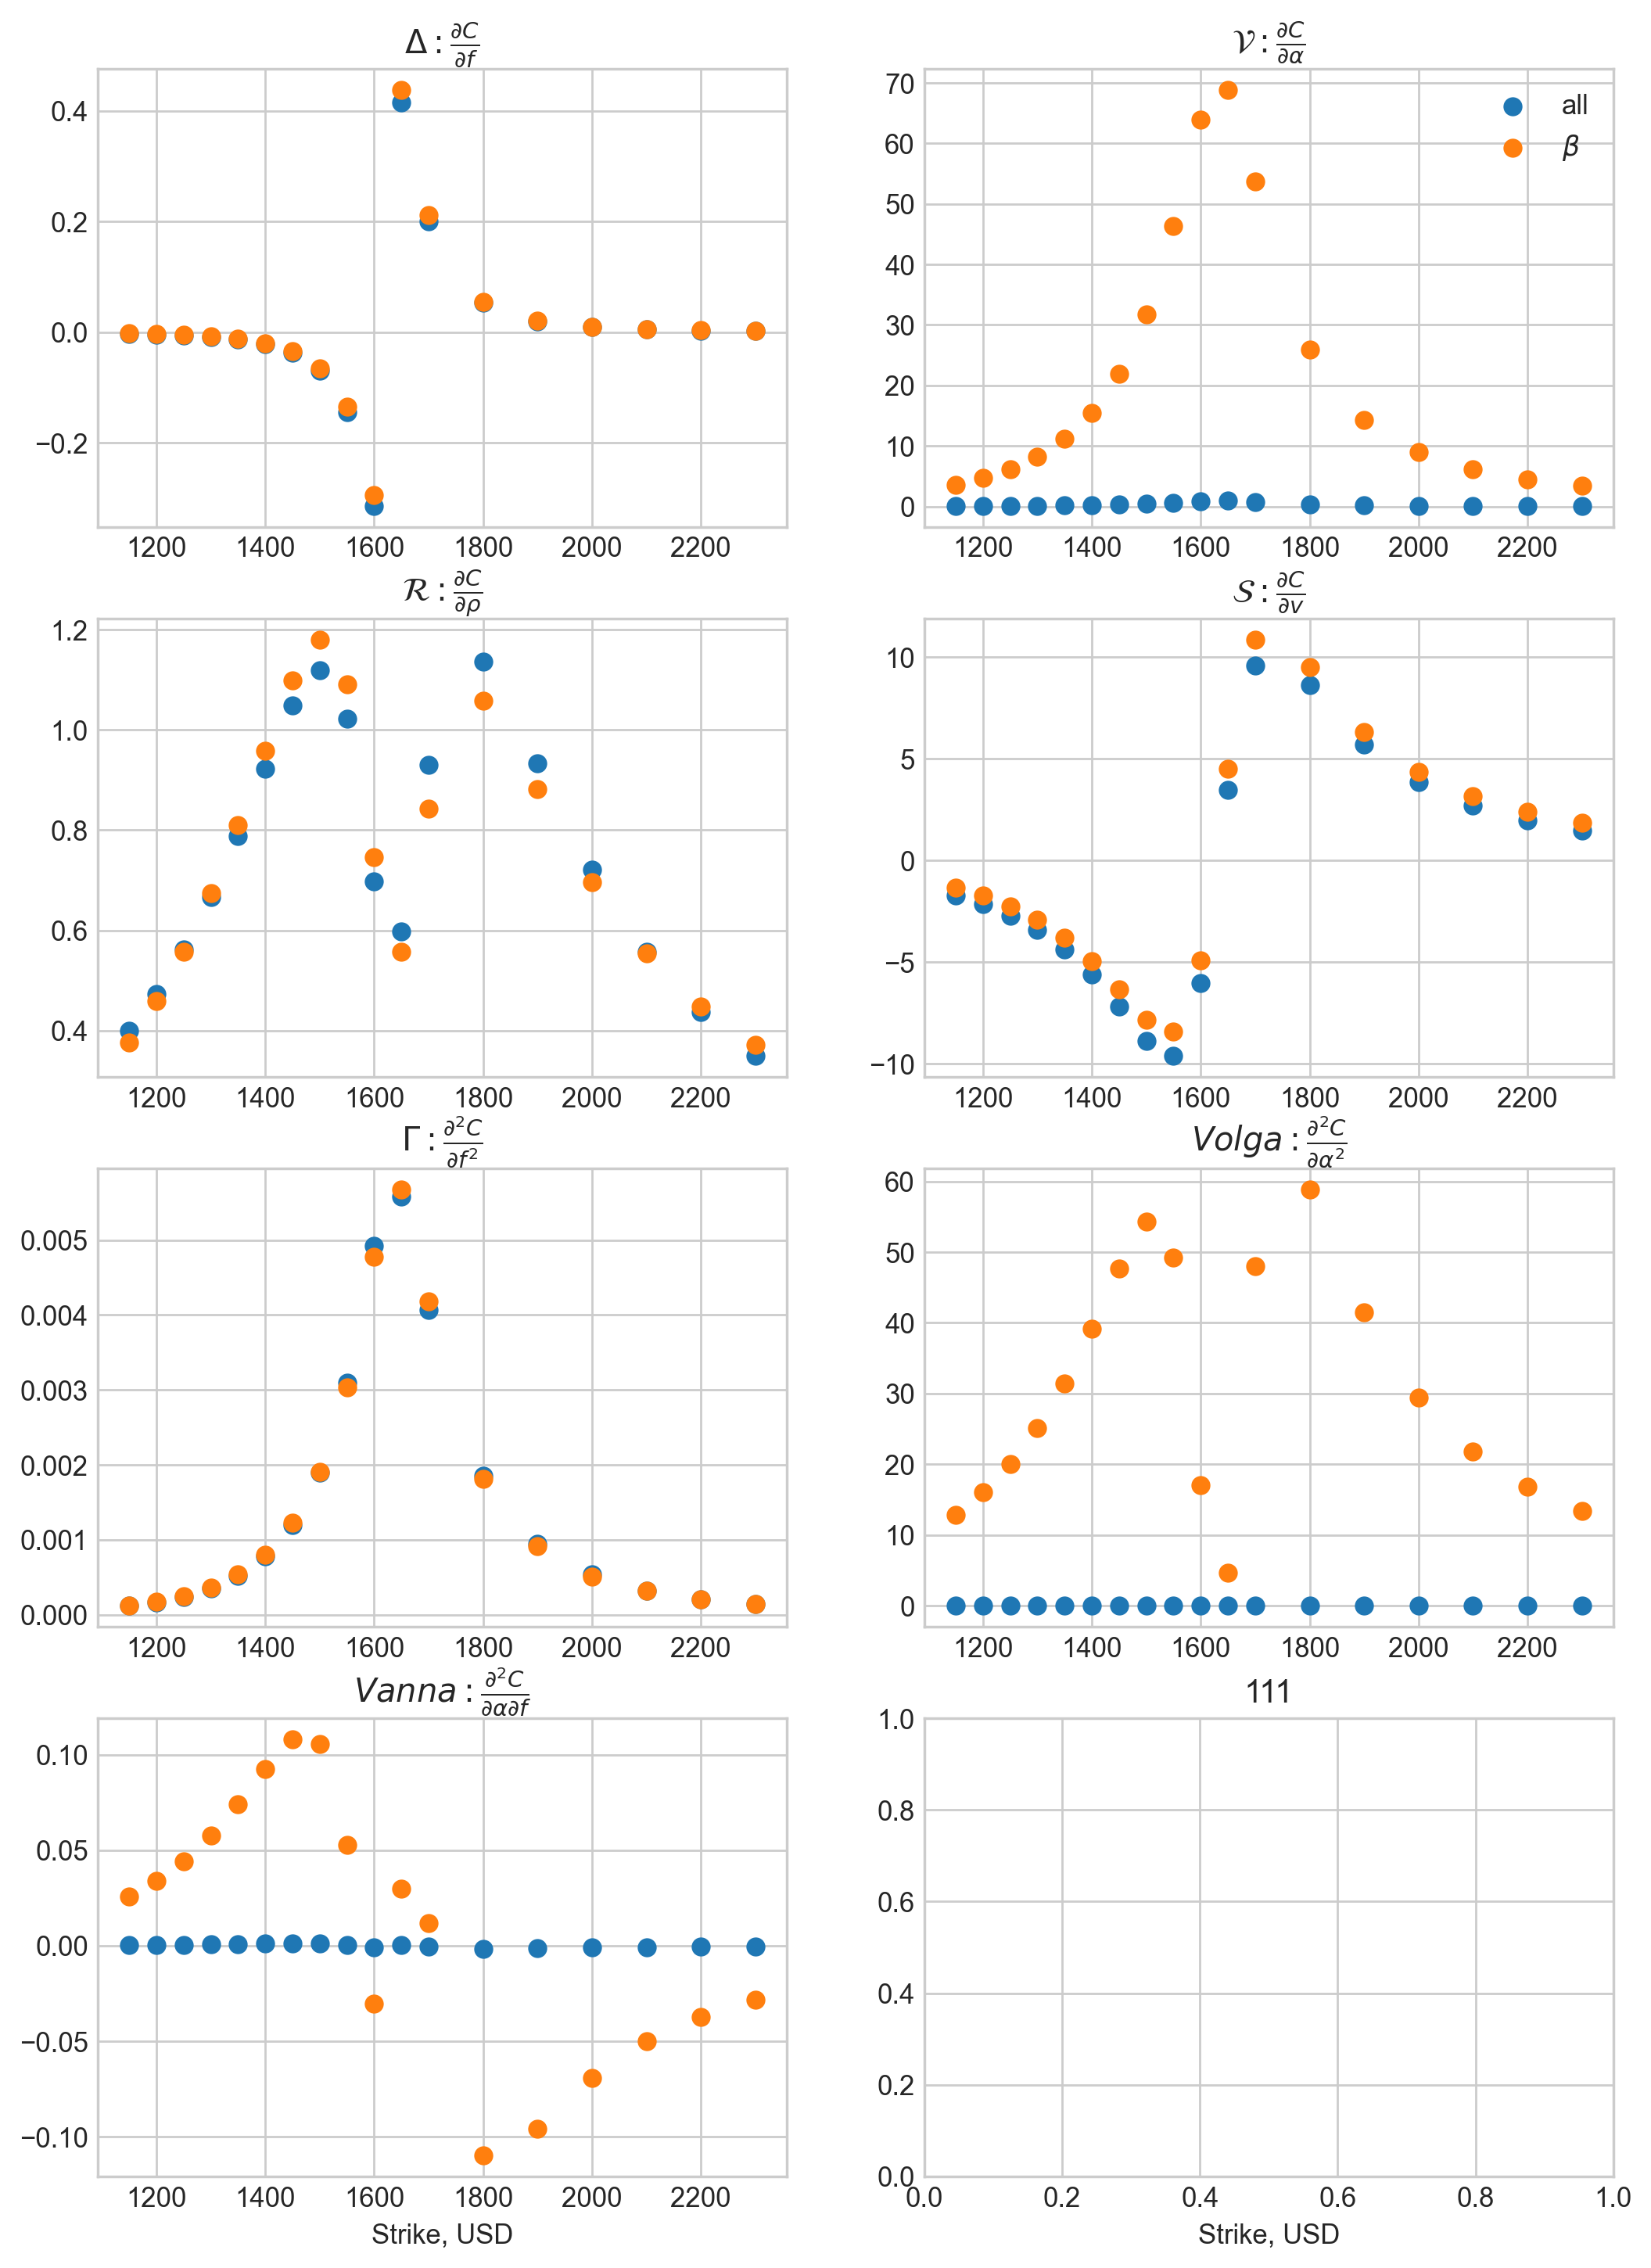

In [8]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0]["dt"]

alpha = np.float64(1.3) 
v = np.float64(0.7) 
beta = np.float64(0.9) 
rho = np.float64(-0.1) 
start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "beta", beta = 1.0)

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


fig, axs =  plt.subplots(nrows=4, ncols=2, figsize=(10, 14), dpi = 250)
axs[0, 0].scatter(C_all["strike_price"], C_all["delta"], label = "all")
axs[0, 0].scatter(C_beta["strike_price"], C_beta["delta"], label = r"$\beta$")
axs[0, 0].set_title(r"$\Delta: \frac{\partial C}{\partial f}$")
# axs[0, 0].legend()
# axs[0, 0]
# axs[0, 0].set_xlabel("Strike, USD")



axs[0, 1].scatter(C_all["strike_price"], C_all["vega"], label = "all")
axs[0, 1].scatter(C_beta["strike_price"], C_beta["vega"], label = r"$\beta$")
axs[0, 1].set_title(r"$\mathcal{V}: \frac{\partial C}{\partial \alpha}$")
axs[0, 1].legend()
# axs[0, 1].set_xlabel("Strike, USD")


axs[1, 0].scatter(C_all["strike_price"], C_all["rega"], label = "all")
axs[1, 0].scatter(C_beta["strike_price"], C_beta["rega"], label = r"$\beta$")
axs[1, 0].set_title(r"$\mathcal{R}: \frac{\partial C}{\partial \rho}$")
# axs[1, 0].legend()
# axs[1, 0].set_xlabel("Strike, USD")

axs[1, 1].scatter(C_all["strike_price"], C_all["sega"], label = "all")
axs[1, 1].scatter(C_beta["strike_price"], C_beta["sega"], label = r"$\beta$")
axs[1, 1].set_title(r"$\mathcal{S}:\frac{\partial C}{\partial v}$")
# axs[1, 1].legend()


axs[2, 0].scatter(C_all["strike_price"], C_all["gamma"], label = "all")
axs[2, 0].scatter(C_beta["strike_price"], C_beta["gamma"], label = r"$\beta$")
axs[2, 0].set_title(r"$\Gamma: \frac{\partial^2 C}{\partial f^2}$")
# axs[2, 0].legend()


axs[2, 1].scatter(C_all["strike_price"], C_all["volga"], label = "all")
axs[2, 1].scatter(C_beta["strike_price"], C_beta["volga"], label = r"$\beta$")
axs[2, 1].set_title(r"$Volga: \frac{\partial^2 C}{\partial \alpha^2}$")
# axs[2, 1].legend()


axs[3, 0].scatter(C_all["strike_price"], C_all["vanna"], label = "all")
axs[3, 0].scatter(C_beta["strike_price"], C_beta["vanna"], label = r"$\beta$")
axs[3, 0].set_title(r"$Vanna: \frac{\partial^2 C}{\partial \alpha \partial f}$")
# axs[3, 0].legend()
axs[3, 0].set_xlabel("Strike, USD")
axs[3, 1].set_xlabel("Strike, USD")

plt.title("111")
plt.show()


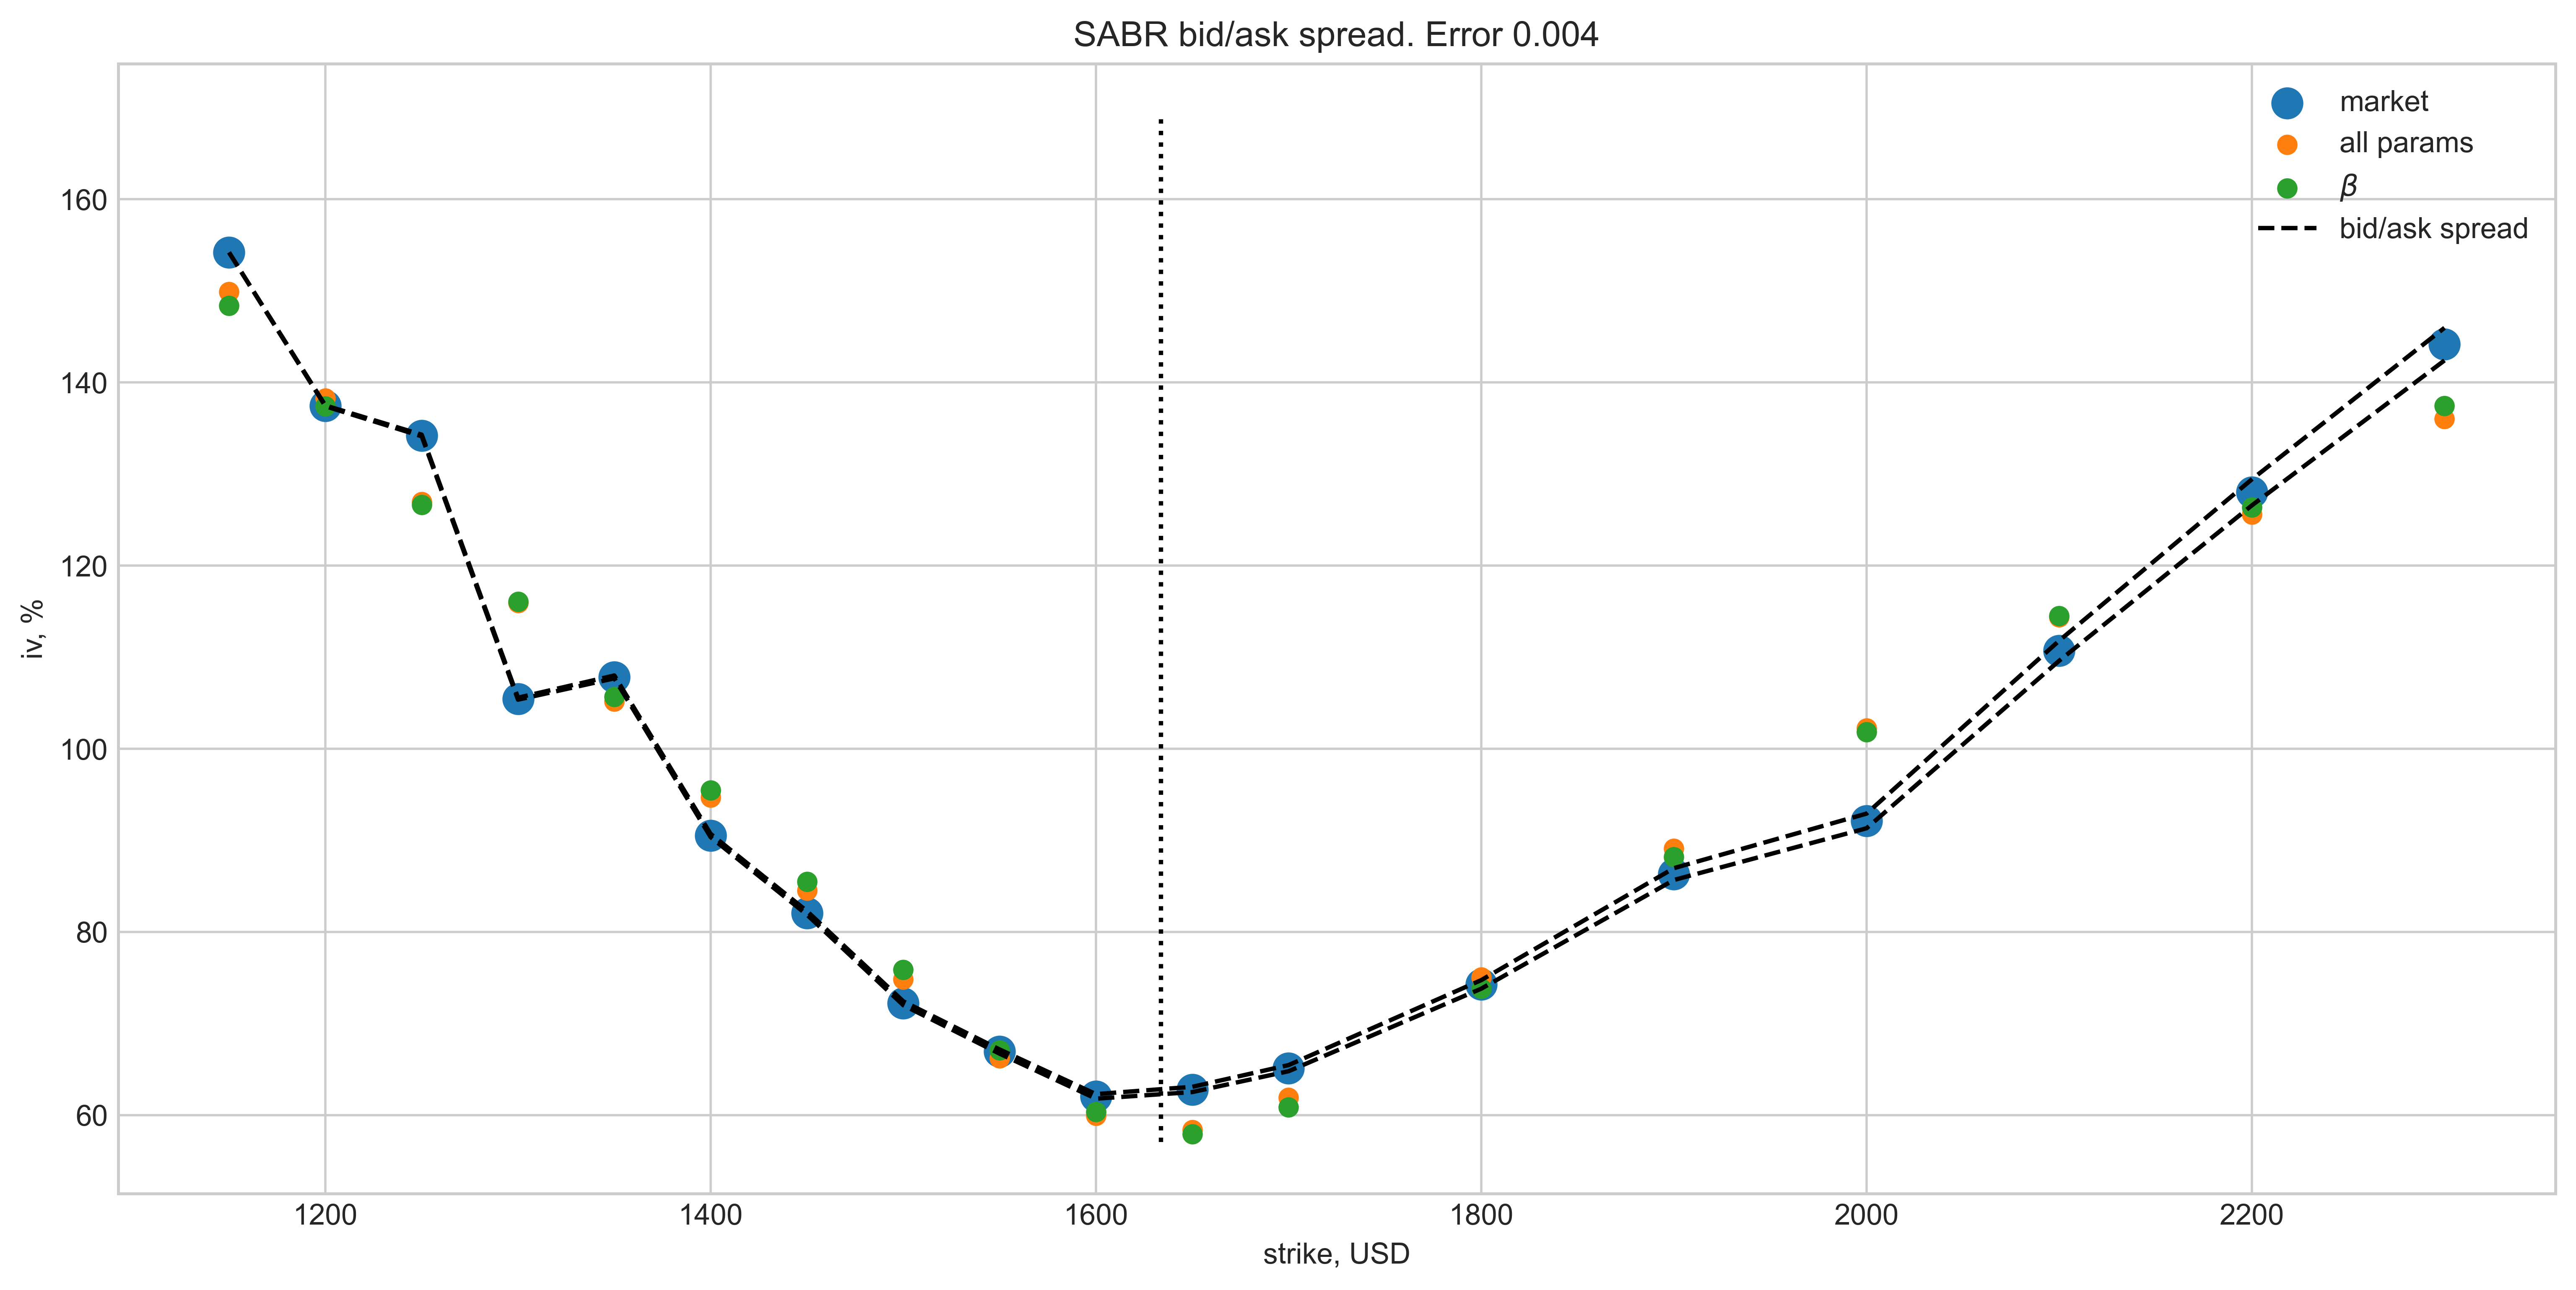

In [9]:
figure(figsize=(15, 7), dpi=500)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)


plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")
C_all = C_all.sort_values("strike_price")

plt.plot(C_all["strike_price"], C_all["ask_iv"], '--', label = "bid/ask spread", color = "black")
plt.plot(C_all["strike_price"], C_all["bid_iv"], '--', color = "black")

plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

err = 0.004
plt.title(f"SABR bid/ask spread. Error {round(err, 3)}")
plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

# Strike for given delta

$$g(K) = \Delta_{BSM} - \delta$$

$$g'(K) = N'(d_1) \frac{\partial d_1}{\partial K} = N'(d_1) \frac{\partial }{\partial K} \left( \frac{  \ln \frac{S}{K} + (r + \frac{\sigma^2(K)}{2})T}{\sigma(K) \sqrt T}  \right)  = $$

$$ = \frac{N'(d_1)}{\sqrt T} \frac{\partial }{\partial K} \left( \frac{\ln \frac{S}{K}}{\sigma(K)} + \frac{rT}{\sigma(K)} + \frac{\sigma(K)T}{2} \right) = $$

$$ = \frac{N'(d_1)}{\sqrt T} \left( -\frac{1}{K\sigma(K)} - \frac{\sigma'(K) \ln \frac{S}{K}}{\sigma^2(K)} - \frac{rT\sigma'(K)}{\sigma^2(K)} + T\sigma'(K)    \right)$$

In [10]:
import src.SABR.sabr_approx_div
reload(src.SABR.sabr_approx_div)
from src.SABR.sabr_approx_div import (
    get_vol, 
    cdf, 
    get_dsigma_dK, 
    get_delta_bsm,
    get_price_bsm,
    get_delta,
    get_gamma,
    get_vega,
    get_rega,
    get_sega,
    ModelParameters, 
    MarketParameters, 
    get_volga,
    get_vanna,
    get_d1,
    get_delta_bsm,
    get_vega_bsm,
    get_gamma_bsm,
    get_volga_bsm,
    get_vanna_bsm
)



# @nb.njit()
def g_deltaspc(model, K, delta, T, F, r, is_call=True):
    market = MarketParameters(
        F=F,
        r=r,
        T=T,
        K=np.array([np.float64(K)]),
        # can lay zero, not needed to calculate volatility
        iv=np.array([np.float64(0.0)]),
        types=np.array([np.bool(is_call)]),
    )
    sigma = get_vol(model, market)[0]
    delta_diff = get_delta_bsm(is_call, sigma, K, T, F, r) - delta
    return delta_diff

# @nb.njit()
def g_deltaspc_prime(model, K, T, F, r, is_call):
    market = MarketParameters(
        F=F,
        r=r,
        T=T,
        K=np.array([np.float64(K)]),
        # can lay zero, not needed to calculate iv
        iv=np.array([np.float64(0.0)]),
        types=np.array([np.bool(is_call)]),
    )
    sigma = get_vol(model, market)[0]
    dsigma_dk = get_dsigma_dK(model, K, T, F)
    d1 = get_d1(sigma, K, T, F, r)
    return np.exp(-d1**2 / 2)/np.sqrt(T)*(- 1/(K*sigma) - dsigma_dk*np.log(F/K)/sigma**2 - r*T*dsigma_dk/sigma**2 + T*dsigma_dk)
    


# @nb.njit()
def delta_to_chain(model, K_l, K_r, delta, F, T, r, is_call=True, tol=10**-12):
    delta_left_strike = g_deltaspc(model, K_l, delta, T, F, r, is_call)
    delta_right_strike = g_deltaspc(model, K_r, delta, T, F, r, is_call)
#     print(f"Borders of delta with strike borders [{K_l}, {K_r}]")
#     print("Delta left strike", delta_left_strike + delta)
#     print("Delta right strike", delta_right_strike + delta)
    if delta_left_strike*delta_right_strike > 0:
        print('no zero at the initial interval')
        return 0.
    else:
        K = (K_l + K_r) / 2
        epsilon = g_deltaspc(model, K, delta, T, F, r, is_call)
        grad = g_deltaspc_prime(model, K, T, F, r, is_call)
        i = 0
        while abs(epsilon) > tol and i < 100: 
            if abs(grad) > 1e-6:
                K -= epsilon / grad
                if K > K_r or K < K_l:
                    K = (K_l + K_r) / 2
                    if g_deltaspc(model, K_l, delta, T, F, r, is_call)*epsilon > 0:
                        K_l = K
                    else:
                        K_r = K
                    K = (K_l + K_r) / 2
            else:
                if g_deltaspc(model, K_l, delta, T, F, r, is_call)*epsilon > 0:
                    K_l = K
                else:
                    K_r = K
                K = (K_l + K_r) / 2
            
            epsilon = g_deltaspc(model, K, delta, T, F, r, is_call)
            grad = g_deltaspc_prime(model, K, T, F, r, is_call)
            i += 1
        print("eps", epsilon)
        return K
    
# set model params
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(1.0), np.float64(-0.10620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
K_l = 1300
K_r = 1800
delta = 0.1
F = 1200
T = 0.01
r = 0.0
is_call = True
found_strike = delta_to_chain(model = model, K_l=K_l, K_r=K_r, 
               delta=delta, 
               F=F, T=T, r=r, is_call=is_call)
market = MarketParameters(
        F=F,
        r=r,
        T=T,
        # put found strike here
        K=np.array([np.float64(found_strike)]),
        iv=np.array([np.float64(0.0)]),
        types=np.array([np.bool(is_call)]),
    )
print("Found strike", found_strike)
# check
sigma = get_vol(model, market)[0]
delta_of_found_strike = get_delta_bsm(is_call, sigma, found_strike, T, F, r)
print("Needed delta", delta)
print("Found delta", delta_of_found_strike)

eps 7.638750743055311e-13
Found strike 1363.3296386274917
Needed delta 0.1
Found delta 0.10000000000076388


# Risk-reversal, butterfly

In [11]:
# Just fix some model
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(1.0), np.float64(-0.10620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
#fix params
delta = 0.25
F = 1200
T = 0.01
r = 0.0

# at the money straddle
market_ATM = MarketParameters(F=F, r=r, T=T, K=np.array([np.float64(F)]),
        iv=np.array([np.float64(0.0)]), types=np.array([np.bool(True)]),)
sigma_ATM = get_vol(model, market_ATM)[0]
print("Found ATM sigma", sigma_ATM)

# the risk-reversal, butterfly
found_strike_call = delta_to_chain(model = model, K_l=F, K_r=F+1000, 
               delta=delta, 
               F=F, T=T, r=r, is_call=True)

found_strike_put = delta_to_chain(model = model, K_l=F-1000, K_r=F, 
               delta=-delta, 
               F=F, T=T, r=r, is_call=False)

print(f"CALL strike with delta = {delta}: {found_strike_call}")
print(f"PUT strike with delta = {delta}: {found_strike_put}")
market_delta_call = MarketParameters(F=F, r=r, T=T, K=np.array([np.float64(found_strike_call)]),
        iv=np.array([np.float64(0.0)]), types=np.array([np.bool(True)]),)
sigma_RR_call = get_vol(model, market_delta_call)[0]
print("Found RR CALL sigma", sigma_RR_call)

market_delta_put = MarketParameters(F=F, r=r, T=T, K=np.array([np.float64(found_strike_put)]),
        iv=np.array([np.float64(0.0)]), types=np.array([np.bool(False)]),)
sigma_RR_put = get_vol(model, market_delta_put)[0]
print("Found RR PUT sigma", sigma_RR_put)
print("RR sigma", sigma_RR_call - sigma_RR_put)
print("BB sigma", 1/2*(sigma_RR_call + sigma_RR_put) - sigma_ATM)


print("CHECKS")
print(f"Delta of call {get_delta_bsm(True, sigma_RR_call, found_strike_call, T, F, r)}")
print(f"Delta of put {get_delta_bsm(False, sigma_RR_put, found_strike_put, T, F, r)}")

Found ATM sigma 0.7453210343773984
eps 9.580114479490476e-13
eps 7.489564524121306e-13
CALL strike with delta = 0.25: 1269.5229938765915
PUT strike with delta = 0.25: 1138.430147338519
Found RR CALL sigma 0.788865264474723
Found RR PUT sigma 0.8322519749983313
RR sigma -0.04338671052360821
BB sigma 0.06523758535912871
CHECKS
Delta of call 0.250000000000958
Delta of put -0.24999999999925104


# BB and RR dynamics on real data

In [34]:
    
def get_price_bsm_for_sigma(
    sigma: float,
    option_type: str,
    K: float,
    T: float,
    F: float,
    r: float = 0.0,
    ):
    d1 = get_d1(sigma, K, T, F, r)
    d2 = d1 - sigma * np.sqrt(T)
    p = 1 if option_type else -1
    return p * F * cdf(p * d1) - p * K * np.exp(-r * T) * cdf(p * d2)


def unexplained_forward_pnl(
    strikes: list, 
    is_call: list,
    tenor: float, 
    new_tenor: float,
    forward: float,
    r: float,
    new_forward: float,
    model: ModelParameters, 
    new_model: ModelParameters
):
    zero_iv = np.array([0.0, 0.0, 0.0])
    market = MarketParameters(F=forward, r=r, T=tenor, K=strikes, 
                              iv=zero_iv, types=is_call)
    iv = get_vol(model, market)
    new_market = MarketParameters(F=new_forward, r=r, T=new_tenor, K=strikes, 
                              iv=zero_iv, types=is_call)
    new_iv = get_vol(new_model, new_market)
    deltas, gammas, vegas, regas, segas, volgas, vannas = [], [], [], [], [], [], []
    deltas_bsm, vegas_bsm, gammas_bsm, volgas_bsm, vannas_bsm = [], [], [], [], []
    n = len(strikes)
    
    
    for i in range(n):
        # collect sabr greeks
        deltas.append(get_delta(model, is_call[i], iv[i], strikes[i], tenor, forward))
        gammas.append(get_gamma(model, is_call[i], iv[i], strikes[i], tenor, forward))
        vegas.append(get_vega(model, is_call[i], iv[i], strikes[i], tenor, forward))
        regas.append(get_rega(model, is_call[i], iv[i], strikes[i], tenor, forward))
        segas.append(get_sega(model, is_call[i], iv[i], strikes[i], tenor, forward))
        volgas.append(get_volga(model, is_call[i], iv[i], strikes[i], tenor, forward))
        vannas.append(get_vanna(model, is_call[i], iv[i], strikes[i], tenor, forward))
        
        # collect bsm greeks
        deltas_bsm.append(get_delta_bsm(is_call[i], iv[i], strikes[i], tenor, forward))
        gammas_bsm.append(get_gamma_bsm(iv[i], strikes[i], tenor, forward))
        vegas_bsm.append(get_vega_bsm(iv[i], strikes[i], tenor, forward))
        vannas_bsm.append(get_vanna_bsm(iv[i], strikes[i], tenor, forward))
        volgas_bsm.append(get_volga_bsm(iv[i], strikes[i], tenor, forward))
        
    unexplained_pnl_strangle = 0.0
    unexplained_pnl_risk_reversal = 0.0
    unexplained_pnl_butterfly = 0.0
    
    unexplained_pnl_strangle_bsm = 0.0
    unexplained_pnl_risk_reversal_bsm = 0.0
    unexplained_pnl_butterfly_bsm = 0.0

        
    for i in range(n):
        pv = get_price_bsm(model=model, F=forward, K=strikes[i], T=tenor, r=r, option_type=is_call[i])    
        new_pv = get_price_bsm(model=new_model, F=new_forward, K=strikes[i], T=new_tenor, r=r, option_type=is_call[i])
        
        # вот тут не совсем правильно сувать iv из sabr, надо как-то попроавить
        pv_bsm = get_price_bsm_for_sigma(iv[i], is_call[i], strikes[i], tenor, forward)
        new_pv_bsm = get_price_bsm_for_sigma(new_iv[i], is_call[i], strikes[i], new_tenor, new_forward)
        # sabr sensitivities
        delta_sens = deltas[i] * (new_forward - forward)
        gamma_sens = 0.5 * gammas[i] * (new_forward - forward)**2
        vega_sens = vegas[i]* (new_model.alpha - model.alpha)
        rega_sens = regas[i]* (new_model.v - model.v)
        sega_sens = segas[i]* (new_model.rho - model.rho)
        volga_sens = 0.5*volgas[i]*(new_model.alpha - model.alpha)**2
        vanna_sens = 0.5*vannas[i]*(new_model.alpha - model.alpha)*(new_forward - forward)
        # BSM senstitivities
        delta_sens_bsm = deltas_bsm[i] * (new_forward - forward)
        gamma_sens_bsm = 0.5 * gammas_bsm[i] * (new_forward - forward)**2
        vega_sens_bsm = vegas_bsm[i]* (new_iv[i] - iv[i])
        volga_sens_bsm = 0.5*volgas_bsm[i]*(new_iv[i] - iv[i])**2
        vanna_sens_bsm = 0.5*vannas_bsm[i]*(new_iv[i] - iv[i])*(new_forward - forward)
        
        up_tmp = (new_pv - pv - delta_sens - gamma_sens - vega_sens - rega_sens - sega_sens - volga_sens - vanna_sens)
        up_tmp_bsm = (new_pv_bsm - pv_bsm - delta_sens_bsm - gamma_sens_bsm - vega_sens_bsm - volga_sens_bsm - vanna_sens_bsm)
        
        # in case of risk-reversal we buy call and sell put
        if i < 2:
            if is_call[i]:
                unexplained_pnl_risk_reversal+=up_tmp
                # bsm
                unexplained_pnl_risk_reversal_bsm+=up_tmp_bsm
            else:
                unexplained_pnl_risk_reversal-=up_tmp
                # bsm
                unexplained_pnl_risk_reversal_bsm-=up_tmp_bsm

            # in case of strangle we by call and put
            unexplained_pnl_strangle+=up_tmp
            unexplained_pnl_butterfly+=up_tmp
            # bsm
            unexplained_pnl_strangle_bsm+=up_tmp_bsm
            unexplained_pnl_butterfly_bsm+=up_tmp_bsm
        if i == 2:
            unexplained_pnl_butterfly = unexplained_pnl_butterfly/2 - up_tmp 
            unexplained_pnl_butterfly_bsm = unexplained_pnl_butterfly_bsm/2 - up_tmp_bsm
    return unexplained_pnl_strangle, unexplained_pnl_risk_reversal, unexplained_pnl_butterfly, unexplained_pnl_strangle_bsm, unexplained_pnl_risk_reversal_bsm, unexplained_pnl_butterfly_bsm



        

eps -7.899653153842223e-13
Strike for call 2003.9861751094713
eps 7.117917366628035e-13
Strike for put 1385.1511790816166
   
SABR RR std 0.001067833626811712
BSM RR std 0.0006770577615533008
   
SABR SS std 0.0018822292946320545
BSM SS std 0.002298066428375467
  
SABR BB std 0.0019066833685730839
BSM BB std 0.001140828038105302


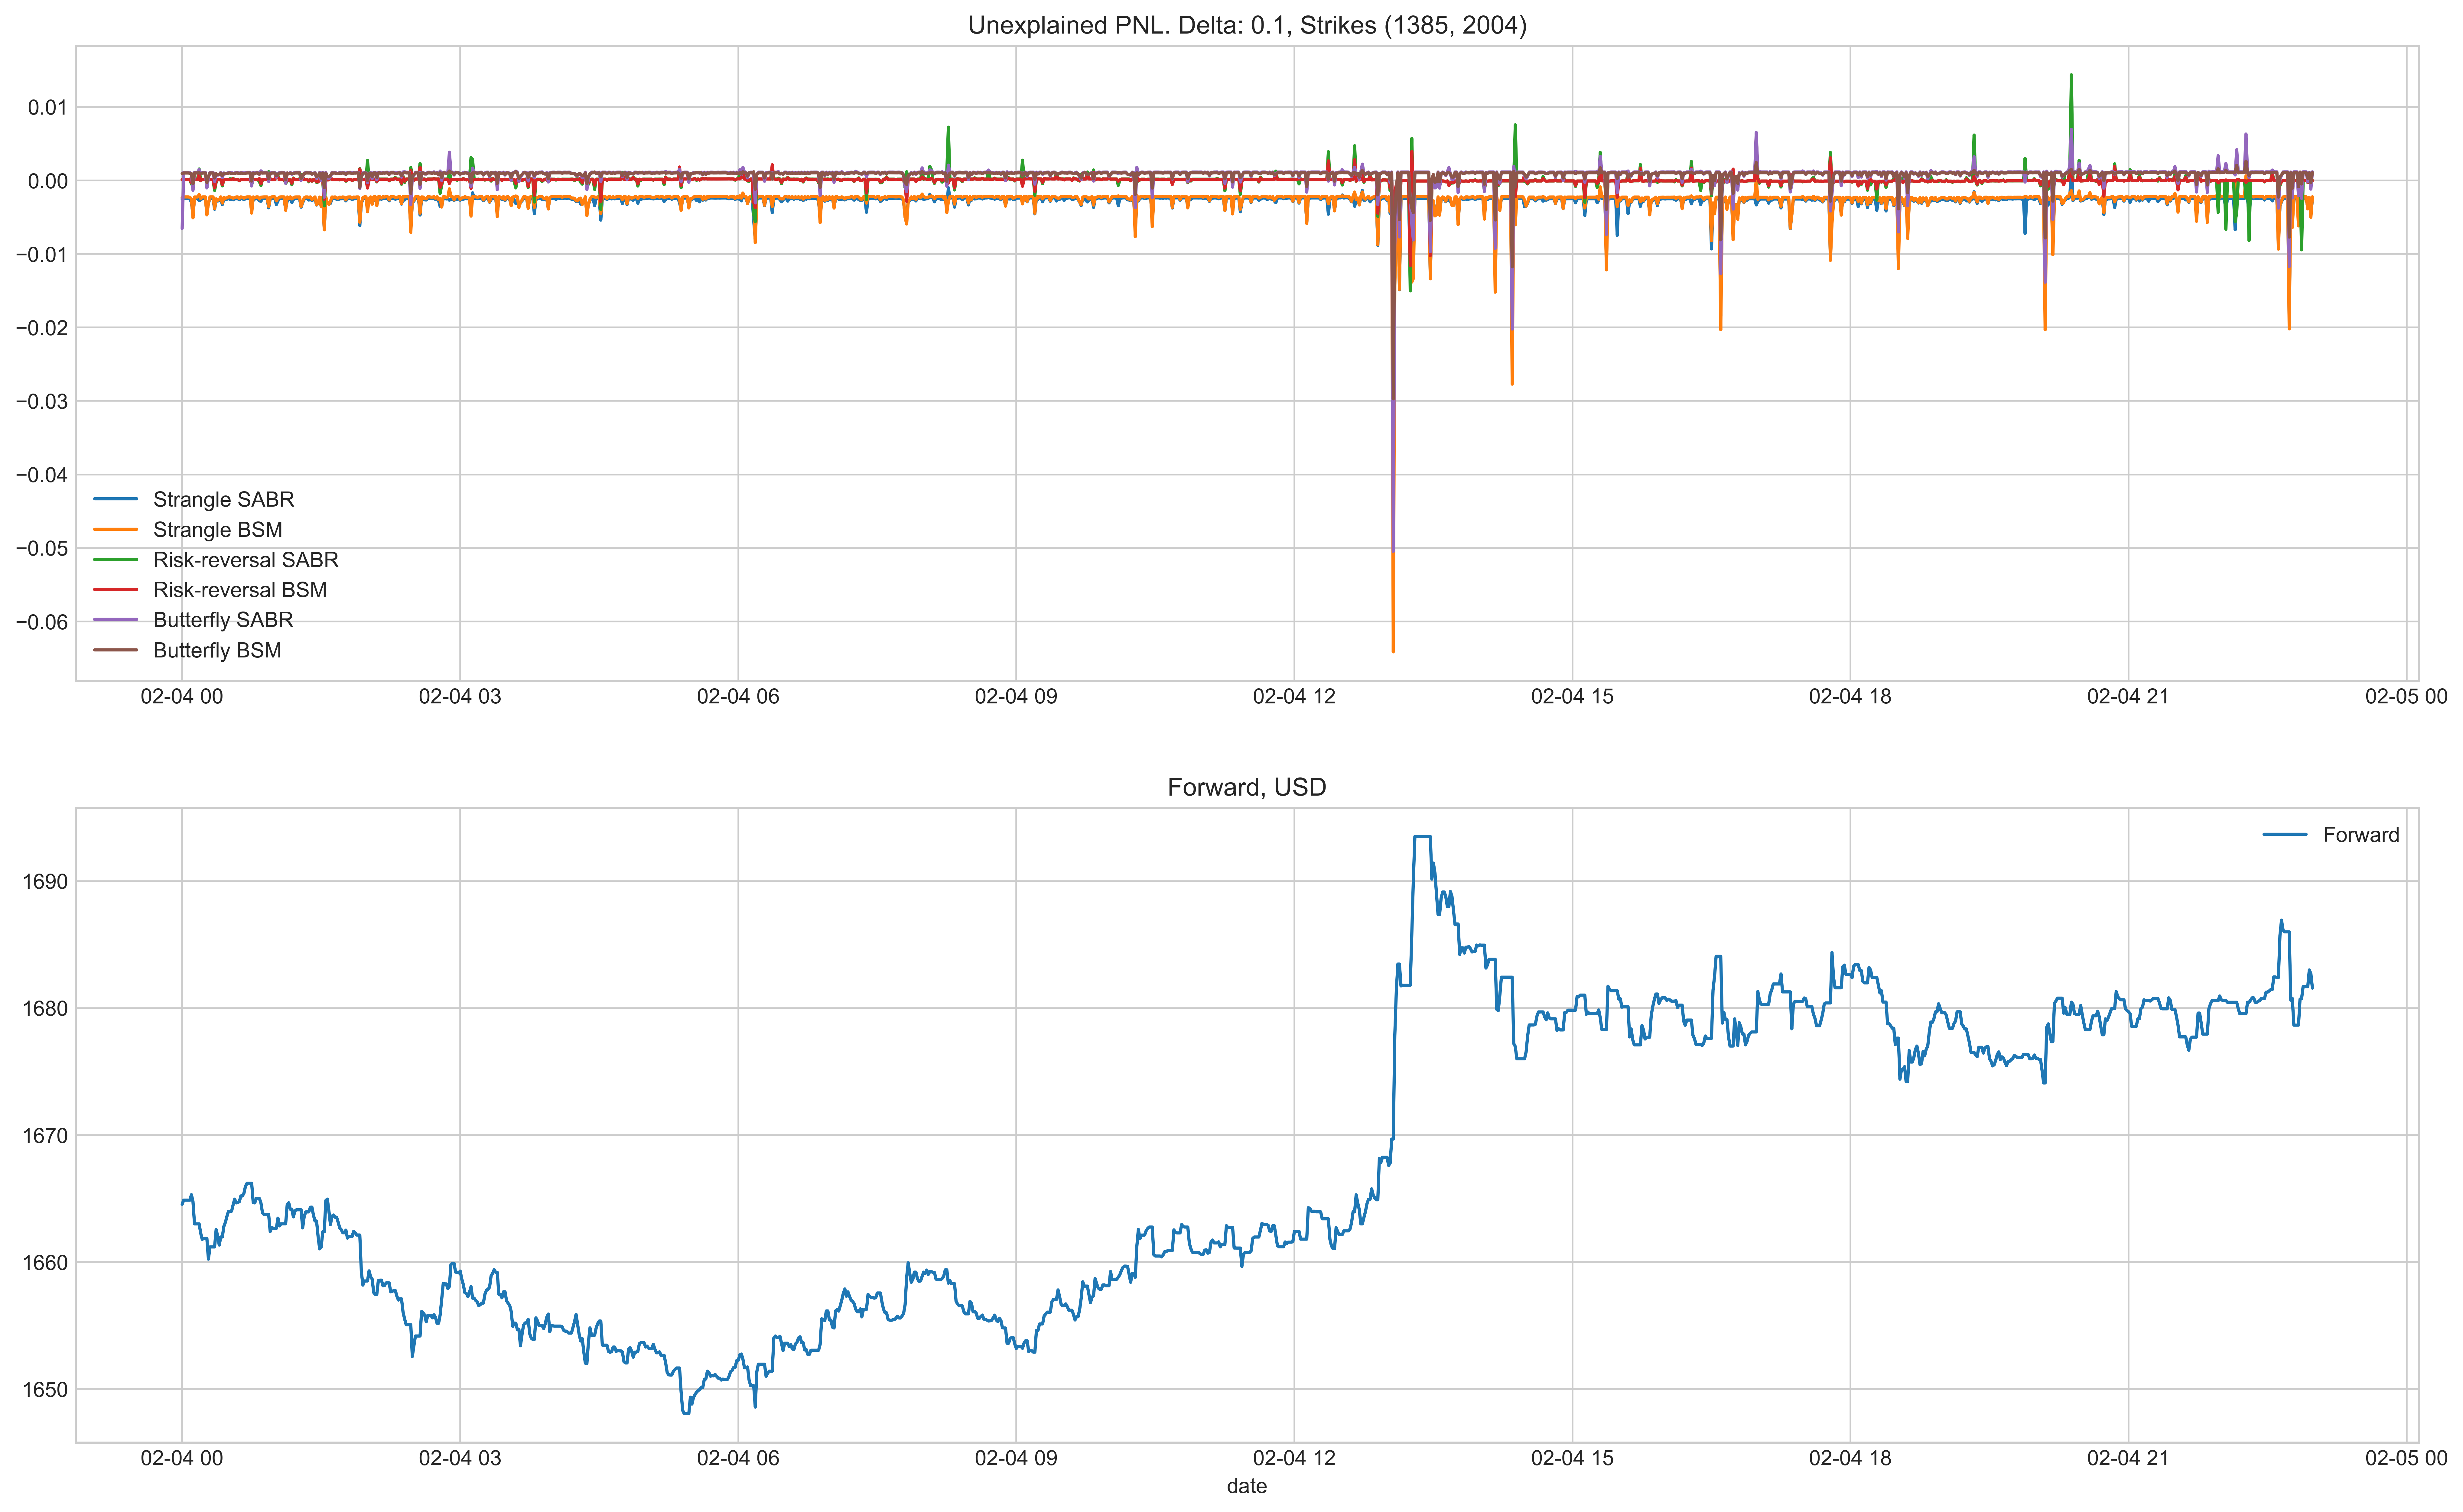

In [147]:
# drop duplicates not needed for counting pnl
df_pnl = df_for_pnl[["underlying_price", "rho", "volvol", "alpha", "beta", "timestamp", "tau"]].drop_duplicates()
df_pnl = df_pnl.sort_values("timestamp")
# get params from next tick
for col in ["underlying_price", "rho", "alpha", "beta", "volvol", "tau"]:
    df_pnl[f"new_{col}"] = df_pnl[col].shift(-1)
df_pnl = df_pnl[~df_pnl["new_underlying_price"].isna()]

# fix strikes with first tick market data
first_tick = df_pnl[df_pnl["timestamp"] == df_pnl["timestamp"].min()].iloc[0]
first_model = ModelParameters(alpha = first_tick["alpha"], v = first_tick["volvol"], 
                              beta = first_tick["beta"], rho = first_tick["rho"])
F, T, r = first_tick["underlying_price"], first_tick["tau"], 0.0
delta = 0.1

# find call strike with fixed delta
found_strike_call = delta_to_chain(model = first_model, K_l=F, K_r=F+1000, 
               delta=delta, F=F, T=T, r=r, is_call=True)
print(f"Strike for call {found_strike_call}")

# find put strike with fixed delta
found_strike_put = delta_to_chain(model = model, K_l=F-1000, K_r=F, 
               delta=-delta, F=F, T=T, r=r, is_call=False)
print(f"Strike for put {found_strike_put}")

unexp_pnls_strangle = []
unexp_pnls_rr = []
unexp_pnls_bb = []

unexp_pnls_strangle_bsm = []
unexp_pnls_rr_bsm = []
unexp_pnls_bb_bsm = []

timestamps = []

for ts in sorted(df_pnl["timestamp"].unique()):
    ts_df = df_pnl[df_pnl["timestamp"] == ts].copy()
    row = ts_df.iloc[0]
    alpha, beta, v, rho = row["alpha"], row["beta"], row["volvol"], row["rho"]
    new_alpha, new_beta, new_v, new_rho = row["new_alpha"], row["new_beta"], row["new_volvol"], row["new_rho"]
    forward, tenor = row["underlying_price"], row["tau"]
    new_forward, new_tenor = row["new_underlying_price"], row["new_tau"]
    model = ModelParameters(alpha = alpha, beta = beta, v = v, rho = rho)
    new_model = ModelParameters(alpha = new_alpha, beta = new_beta, v = new_v, rho = new_rho)
    unexp_pnl_strangle, unexp_pnl_rr, unexp_pnl_bb, unexp_pnl_strangle_bsm, unexp_pnl_rr_bsm, unexp_pnl_bb_bsm  = unexplained_forward_pnl(
        # also add ATM as forward == strike
        strikes = np.array([found_strike_put, found_strike_call, F]), 
        is_call=np.array([False, True, True]),
        tenor = tenor, 
        new_tenor = new_tenor,
        forward=forward, 
        new_forward=new_forward, 
        model = model,
        new_model = new_model,
        r = r)
    unexp_pnls_strangle.append(unexp_pnl_strangle)
    unexp_pnls_rr.append(unexp_pnl_rr)
    unexp_pnls_bb.append(unexp_pnl_bb)
    
    unexp_pnls_strangle_bsm.append(unexp_pnl_strangle_bsm)
    unexp_pnls_rr_bsm.append(unexp_pnl_rr_bsm)
    unexp_pnls_bb_bsm.append(unexp_pnl_bb_bsm)
    timestamps.append(ts)
    

fig, axs =  plt.subplots(nrows=2, ncols=1, figsize=(20, 12), dpi = 500)

on = np.ones(len(unexp_pnls_strangle))
# axs[0].plot(timestamps, unexp_pnls_strangle - on*np.mean(unexp_pnls_strangle), label = "Strangle SABR")
# axs[0].plot(timestamps, unexp_pnls_strangle_bsm - on*np.mean(unexp_pnls_strangle_bsm), label = "Strangle BSM")

# axs[0].plot(timestamps, unexp_pnls_rr - on*np.mean(unexp_pnls_rr), label = "Risk-reversal SABR")
# axs[0].plot(timestamps, unexp_pnls_rr_bsm - on*np.mean(unexp_pnls_rr_bsm), label = "Risk-reversal BSM")

# axs[0].plot(timestamps, unexp_pnls_bb - on*np.mean(unexp_pnls_bb), label = "Butterfly SABR")
# axs[0].plot(timestamps, unexp_pnls_bb_bsm- on*np.mean(unexp_pnls_bb_bsm), label = "Butterfly BSM")


axs[0].plot(timestamps, unexp_pnls_strangle, label = "Strangle SABR")
axs[0].plot(timestamps, unexp_pnls_strangle_bsm , label = "Strangle BSM")
axs[0].plot(timestamps, unexp_pnls_rr, label = "Risk-reversal SABR")
axs[0].plot(timestamps, unexp_pnls_rr_bsm, label = "Risk-reversal BSM")
axs[0].plot(timestamps, unexp_pnls_bb, label = "Butterfly SABR")
axs[0].plot(timestamps, unexp_pnls_bb_bsm, label = "Butterfly BSM")

axs[0].set_title(f"Unexplained PNL. Delta: {delta}, Strikes {round(found_strike_put), round(found_strike_call)}")
axs[0].legend()

axs[1].plot(df_pnl["timestamp"], df_pnl["underlying_price"], label = r"Forward")
axs[1].legend()
axs[1].set_title(r"Forward, USD")

plt.xlabel("date")

print("   ")
print("SABR RR std", np.std(unexp_pnls_rr))
print("BSM RR std", np.std(unexp_pnls_rr_bsm))
print("   ")
print("SABR SS std", np.std(unexp_pnls_strangle))
print("BSM SS std", np.std(unexp_pnls_strangle_bsm))
print("  ")
print("SABR BB std", np.std(unexp_pnls_bb))
print("BSM BB std", np.std(unexp_pnls_bb_bsm))


    

In [149]:
def quant(dataset, left = 5, right = 5):
    dataset = np.array(dataset)
    lo = np.percentile(dataset, left)
    hi = np.percentile(dataset, 100 - right)
    res = dataset[(dataset > lo) & (dataset < hi)] 
    return res - np.mean(res)

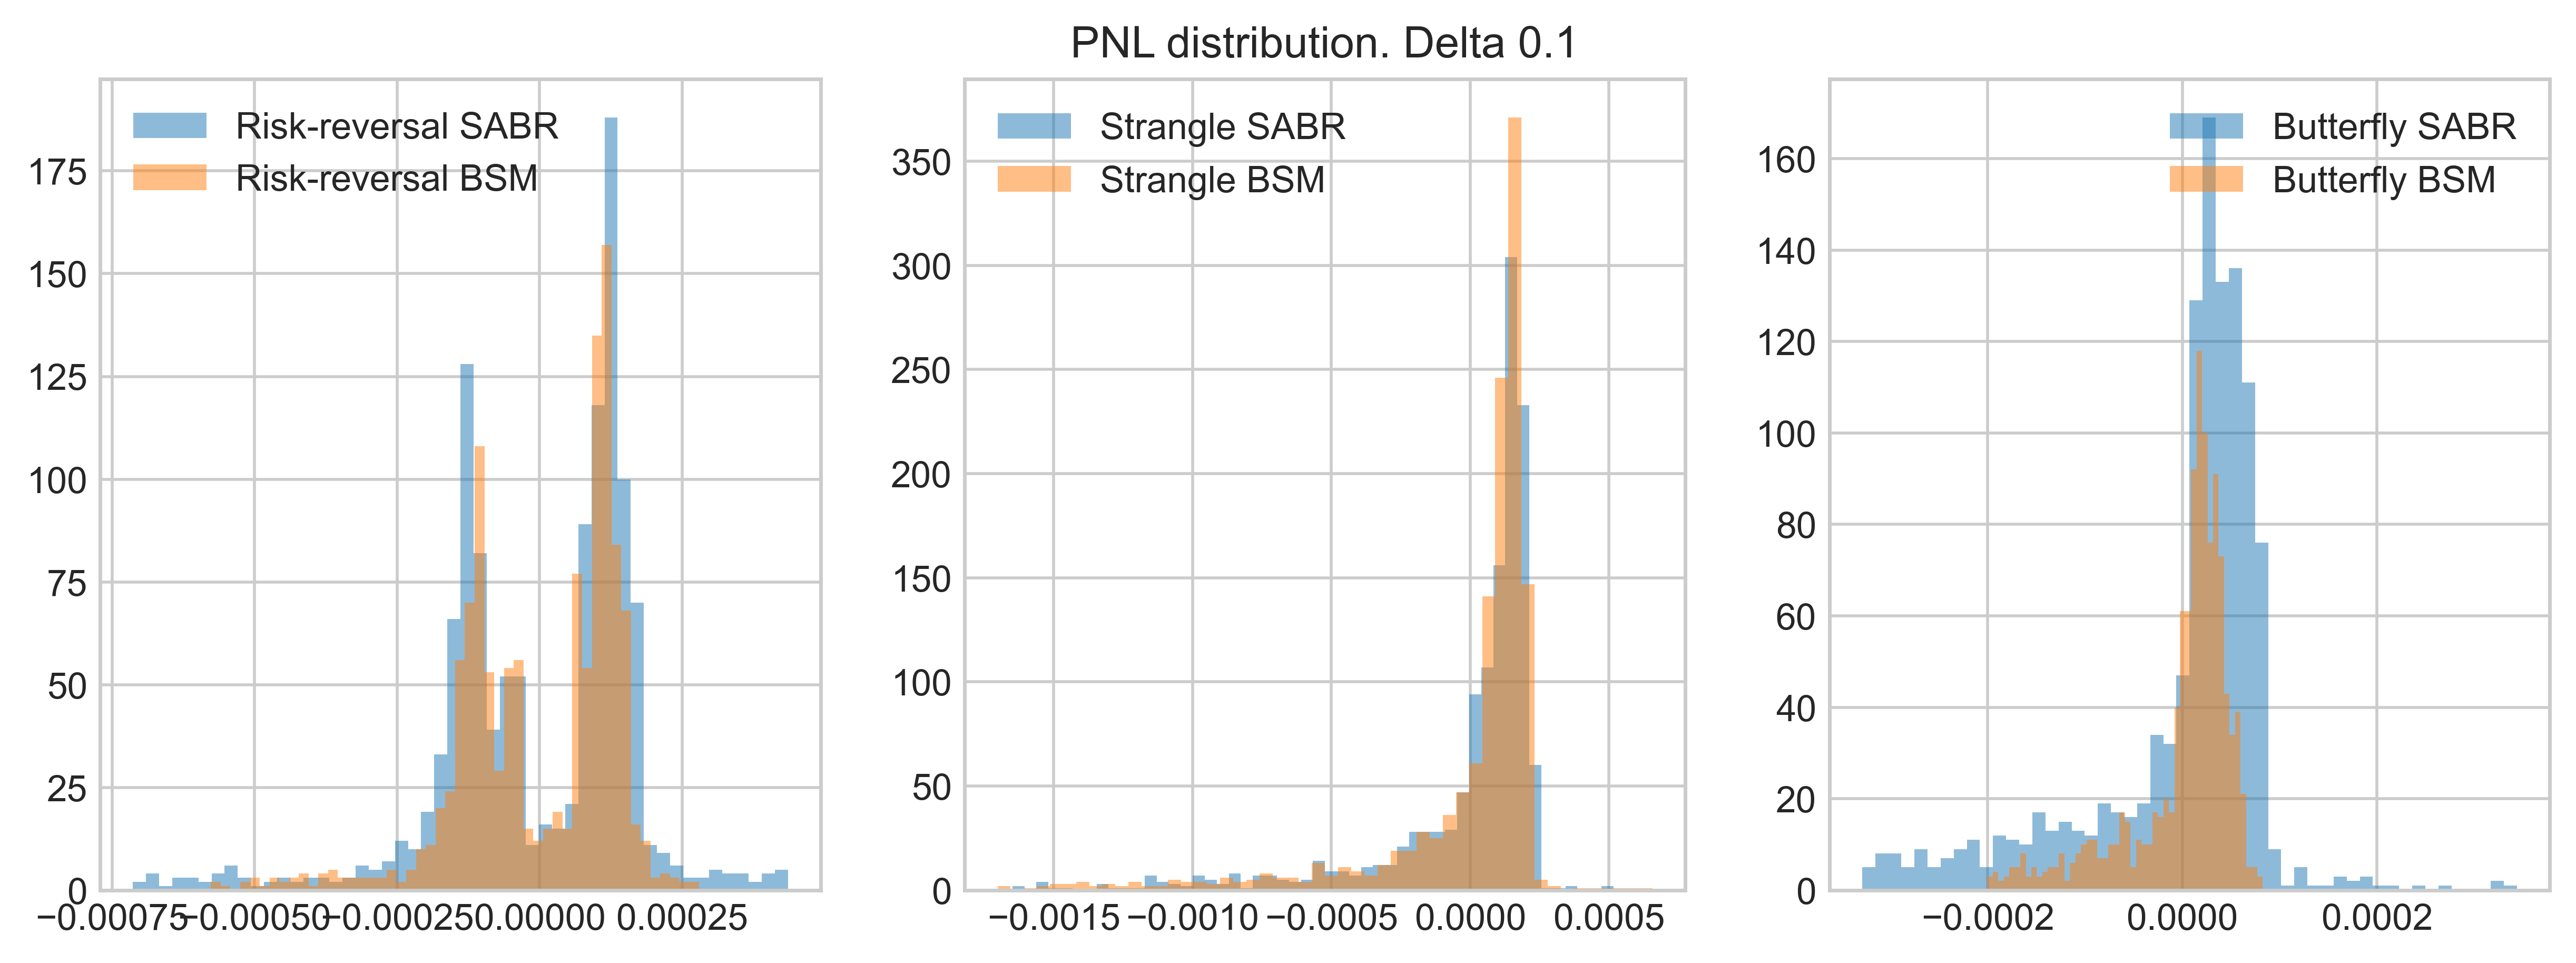

In [150]:
fig, axs =  plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi = 500)

axs[0].hist(quant(unexp_pnls_rr), label = "Risk-reversal SABR", bins = 50, alpha = 0.5)
axs[0].hist(quant(unexp_pnls_rr_bsm), label = "Risk-reversal BSM", bins = 50, alpha = 0.5)
axs[1].hist(quant(unexp_pnls_strangle, 5, 1), label = "Strangle SABR", bins = 50, alpha = 0.5)
axs[1].hist(quant(unexp_pnls_strangle_bsm, 5, 1), label = "Strangle BSM", bins = 50, alpha = 0.5)
axs[2].hist(quant(unexp_pnls_bb, 15, 2), label = "Butterfly SABR", bins = 50, alpha = 0.5)
axs[2].hist(quant(unexp_pnls_bb_bsm, 15, 2), label = "Butterfly BSM", bins = 50, alpha = 0.5)

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[1].set_title(f"PNL distribution. Delta {delta}")
plt.show()

In [134]:
# pd.DataFrame(unexp_pnls_strangle)[0].hist(bins = 100, alpha = 0.5, label = "Strangle")
# pd.DataFrame(unexp_pnls_rr)[0].hist(bins = 100, alpha = 0.5, label = "Risk-reversal")
# pd.DataFrame(unexp_pnls_bb)[0].hist(bins = 100, alpha = 0.5, label = "Butterfly")
# plt.legend()


## Jacobian and d_sigma/dK sanity checks

In [17]:
import src.SABR.sabr_approx_div
reload(src.SABR.sabr_approx_div)
from src.SABR.sabr_approx_div import (get_delta,
                                      get_gamma,
                                      jacobian_sabr,
                                      get_vol,
                                      get_implied_volatility,
                                      get_vega,
                                      get_price_bsm,
                                      get_rega, 
                                      get_sega, 
                                      MarketParameters,
                                      ModelParameters, 
                                      get_dsigma_dK, 
                                      get_dsigma_df,
                                      get_d2_sigma_df2, 
                                      get_d2_sigma_dalpha_df, 
                                      get_volga, 
                                      get_vanna,
                                      get_d2_sigma_dalpha2,
                                      get_vega_bsm
                                     )

def get_first_order_derivative(C_plus, C_min, h):
    return (C_plus - C_min)/(2*h)

def get_second_order_derivative(C0, C_plus, C_min, h):
    return (C_plus+C_min-2*C0)/(h)**2

In [18]:
eps = 0.0001
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(0.9999), np.float64(-0.12620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
# set market with params from random tick
tick = df.sample(1).iloc[0]

F, r, T, K, op_type = (
                          np.float64(tick["underlying_price"]), 
                          np.float64(0.0), 
                          np.float64(tick["tau"]), 
                          np.array([np.float64(tick["strike_price"])]), 
                          # np.array([np.float64(tick["mark_price_usd"])]), 
                          np.array([tick["type"]]))
op_type_bool = True if op_type[0] == "call" else False
op_type_bool = np.array([op_type_bool])
market = MarketParameters(F = F, r = r, T = T, K = K,  iv = np.array([]), types = op_type_bool)


# alpha
sigmas_minus  = get_vol(model=ModelParameters(alpha-eps, v, beta, rho), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha+eps, v, beta, rho), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
dsigma_dalpha, _, _, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("ALPHA")
print(f"Calculated dsigma_dalpha: {dsigma_dalpha[0]}")
numeric_alpha = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dalpha: {numeric_alpha}")
print(" ")


#volvol
sigmas_minus  = get_vol(model=ModelParameters(alpha, v-eps, beta, rho), market=market)
sigmas_plus = get_vol(model=ModelParameters(alpha, v+eps, beta, rho), market=market)
sigmas = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, dsigma_dv, _, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("VOLVOL")
print(f"Calculated dsigma_dv: {dsigma_dv[0]}")
numeric_v = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dv: {numeric_v}")
print(" ")


#rho
sigmas_minus = get_vol(model=ModelParameters(alpha, v, beta, rho-eps), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha, v, beta, rho+eps), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, _, _, dsigma_drho = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("RHO")
print(f"Calculated dsigma_drho: {dsigma_drho[0]}")
numeric_rho = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_drho: {numeric_rho}")
print(" ")


#beta
sigmas_minus  = get_vol(model=ModelParameters(alpha, v, beta-eps, rho), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha, v, beta+eps, rho), market=market)
sigmas  = get_vol(model=ModelParameters(alpha, v, beta, rho), market=market)
_, _, dsigma_dbeta, _ = jacobian_sabr(model=ModelParameters(alpha, v, beta, rho), market=market)

print("BETA")
print(f"Calculated dsigma_dbeta: {dsigma_dbeta[0]}")
numeric_beta = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dbeta: {numeric_beta}")
print(" ")


#dsigma_dk
zero = np.array([0.0])
sigmas_minus  = get_vol(model=model, market=MarketParameters(F, r, T, K-eps, zero, op_type_bool))
sigmas_plus  = get_vol(model=model, market=MarketParameters(F, r, T, K+eps,  zero, op_type_bool))
kega = get_dsigma_dK(model, K[0], T, F)

print("KEGA")
print(f"Calculated dsigma_dK: {kega}")
numeric_kega = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_dK: {numeric_kega}")
print(" ")

#dsigma_df
sigmas_minus  = get_vol(model=model, market=MarketParameters(F-eps, r, T, K, zero, op_type_bool))
sigmas_plus  = get_vol(model=model, market=MarketParameters(F+eps, r, T, K, zero, op_type_bool))
sigmas = get_vol(model=model, market=MarketParameters(F, r, T, K, zero, op_type_bool))
dsigma_df = get_dsigma_df(model, K[0], T, F)
print("dSIGMA_dF")
print(f"Calculated dsigma_df: {dsigma_df}")
numeric_dsigma_df = get_first_order_derivative(sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric dsigma_df: {numeric_dsigma_df}")
print(" ")

#d^2sigma_df^2
d2_sigma_df2 = get_d2_sigma_df2(model, K[0], T, F)
print("d^2SIGMA_dF^2")
print(f"Calculated d2_sigma_df2: {d2_sigma_df2}")
numeric_d2_sigma_df2 = get_second_order_derivative(sigmas[0], sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric d2_sigma_df2: {numeric_d2_sigma_df2}")
print(" ")

#d^2sigma_dalpha^2
sigmas_minus  = get_vol(model=ModelParameters(alpha = alpha-eps, beta = beta, v = v, rho = rho), market=market)
sigmas_plus  = get_vol(model=ModelParameters(alpha = alpha+eps, beta = beta, v = v, rho = rho), market=market)
sigmas = get_vol(model=ModelParameters(alpha = alpha, beta = beta, v = v, rho = rho), market=market)
d2_sigma_dalpha2 = get_d2_sigma_dalpha2(model, K[0], T, F)
print("d^2SIGMA_dALPHA^2")
print(f"Calculated d2_sigma_dalpha2: {d2_sigma_dalpha2}")
numeric_d2_sigma_dalpha2 = get_second_order_derivative(sigmas[0], sigmas_plus[0], sigmas_minus[0], eps)
print(f"Numeric d2_sigma_dalpha2: {numeric_d2_sigma_dalpha2}")
print(" ")

#d^2sigma_dalpha_df
d2_sigma_dalpha_df = get_d2_sigma_dalpha_df(model, K[0], T, F)
print("d^2SIGMA_dF_dALPHA")
print(f"Calculated d2_sigma_dalpha_df: {d2_sigma_dalpha_df}")
dsigma_df_plus = get_dsigma_df(ModelParameters(alpha = alpha+eps, beta = beta, v = v, rho = rho), K[0], T, F)
dsigma_df_minus = get_dsigma_df(ModelParameters(alpha = alpha-eps, beta = beta, v = v, rho = rho), K[0], T, F)
numeric_d2_sigma_df_dalpha = get_first_order_derivative(dsigma_df_plus, dsigma_df_minus, eps)
print(f"Numeric d2_sigma_df_dalpha: {numeric_d2_sigma_df_dalpha}")


ALPHA
Calculated dsigma_dalpha: 1.485829116916566
Numeric dsigma_dalpha: 1.485829120351223
 
VOLVOL
Calculated dsigma_dv: 0.3440442353911597
Numeric dsigma_dv: 0.3440442353985773
 
RHO
Calculated dsigma_drho: -0.410973831708379
Numeric dsigma_drho: -0.4109738298097021
 
BETA
Calculated dsigma_dbeta: 6.894939987715804
Numeric dsigma_dbeta: 6.89494028881299
 
KEGA
Calculated dsigma_dK: -0.004909318165894515
Numeric dsigma_dK: -0.004909318997992074
 
dSIGMA_dF
Calculated dsigma_df: 0.002472084192819542
Numeric dsigma_df: 0.0024720846103498673
 
d^2SIGMA_dF^2
Calculated d2_sigma_df2: -2.6071933462561063e-06
Numeric d2_sigma_df2: -0.00034159342021666816
 
d^2SIGMA_dALPHA^2
Calculated d2_sigma_dalpha2: -0.7736692271368856
Numeric d2_sigma_dalpha2: -0.7736691287618669
 
d^2SIGMA_dF_dALPHA
Calculated d2_sigma_dalpha_df: 0.0006079097826701515
Numeric d2_sigma_df_dalpha: 0.0006079097856679337


## Greeks sanity checks 

In [19]:
alpha, v, beta, rho = np.float64(0.69041447), np.float64(9.96516197), np.float64(0.9), np.float64(-0.15620199)
model = ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho)
# set market with params from random tick
tick = df.sample(1).iloc[0]
F, r, T, K, op_type = (
                          np.float64(tick["underlying_price"]), 
                          np.float64(0.0), 
                          np.float64(tick["tau"]), 
                          np.array([np.float64(tick["strike_price"])]), 
                          np.array([tick["type"]]))
op_type_bool = True if op_type[0] == "call" else False
op_type_bool = np.array([op_type_bool])
eps = 0.0001
market = MarketParameters(F, r, T, K, np.array([0.0]), op_type_bool)


# Delta
prices_minus = get_price_bsm(model, op_type_bool[0], K[0], T, F-eps)
prices_plus = get_price_bsm(model, op_type_bool[0], K[0], T, F+eps)
prices = get_price_bsm(model, op_type_bool[0], K[0], T, F)
vols = get_vol(model, market=market)
delta = get_delta(model, op_type_bool[0], vols[0], K[0], T, F)

print("DELTA")
print(f"Calculated delta: {delta}")
numeric_delta = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric delta: {numeric_delta}")
print(" ")

# Gamma
gamma = get_gamma(model, op_type_bool[0], vols[0], K[0], T, F)
print("GAMMA")
print(f"Calculated gamma: {gamma}")
numeric_gamma = get_second_order_derivative(prices, prices_plus, prices_minus, eps)
print(f"Numeric gamma: {numeric_gamma}")
print(" ")


# Rega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha, v = v-eps, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha, v = v+eps, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
rega = get_rega(model, op_type_bool[0], vols[0], K[0], T, F)

print("REGA")
print(f"Calculated rega: {rega}")
numeric_rega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric rega: {numeric_rega}")
print(" ")


# Sega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho-eps), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho+eps), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
sega = get_sega(model, op_type_bool[0], vols[0], K[0], T, F)

print("SEGA")
print(f"Calculated sega: {sega}")
numeric_sega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric sega: {numeric_sega}")
print(" ")


# Vega
prices_minus = get_price_bsm(ModelParameters(alpha = alpha-eps, v = v, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
prices_plus = get_price_bsm(ModelParameters(alpha = alpha+eps, v = v, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
prices = get_price_bsm(ModelParameters(alpha = alpha, v = v, beta = beta, rho = rho), op_type_bool[0], K[0], T, F)
vols = get_vol(model=model, market=market)
vega = get_vega(model, op_type_bool[0], vols[0], K[0], T, F)

print("VEGA")
print(f"Calculated vega: {vega}")
numeric_vega = get_first_order_derivative(prices_plus, prices_minus, eps)
print(f"Numeric vega: {numeric_vega}")
print(" ")

# Volga
volga = get_volga(model, op_type_bool[0], vols[0], K[0], T, F)
print("VOLGA")
print(f"Calculated volga: {volga}")
numeric_volga = get_second_order_derivative(prices, prices_plus, prices_minus, eps)
print(f"Numeric volga: {numeric_volga}")
print(" ")

# Vanna
print("VANNA")
vanna = get_vanna(model, op_type_bool[0], vols[0], K[0], T, F)
print(f"Calculated vanna: {vanna}")
vols_plus = get_vol(model=ModelParameters(alpha = alpha+eps, beta = beta, v = v, rho = rho), market=market)
vols_minus = get_vol(model=ModelParameters(alpha = alpha-eps, beta = beta, v = v, rho = rho), market=market)
delta_plus = get_delta(ModelParameters(alpha = alpha+eps, beta = beta, v = v, rho = rho), op_type_bool[0], vols_plus[0], K[0], T, F)
delta_minus = get_delta(ModelParameters(alpha = alpha-eps, beta = beta, v = v, rho = rho), op_type_bool[0], vols_minus[0], K[0], T, F)
numeric_vanna = get_first_order_derivative(delta_plus, delta_minus, eps)
print(f"Numeric vanna: {numeric_vanna}")

print("STICKY, NOT 100% EQUAL SO")



DELTA
Calculated delta: -0.0018723321909726483
Numeric delta: -0.001872406301117735
 
GAMMA
Calculated gamma: 0.00016825990783076472
Numeric gamma: 5.6843418860808015e-06
 
REGA
Calculated rega: 3.3698021823518665
Numeric rega: 3.36984559957898
 
SEGA
Calculated sega: -4.199143795402937
Numeric sega: -4.199197841536773
 
VEGA
Calculated vega: 12.988973781569848
Numeric vega: 12.9891411148364
 
VOLGA
Calculated volga: 8.15242486287884
Numeric volga: 8.15157576994352
 
VANNA
Calculated vanna: 0.042195389559294715
Numeric vanna: -0.00295080899014033
STICKY, NOT 100% EQUAL SO
